## AirBnb Host Retention Analysis

The purpose of this notebook is to analyze churn of AirBnb listings, and predict which listings will drop out the following year.

AirBnb is a popular short term rental site where travelers can rent out rooms or even whole homes from hosts for any time from a few days to a month a time.  AirBnb gets a cut of the rental fee from both hosts and renters.  Thus, its business model depends on a sufficient supply of hosts listing their rental on the platform.  From the business perspective, you are likely interested in knowing which hosts are going to drop their listing from the site.  If you had a perfect predictive algorithm that identified listings that were likely to drop-out, perhaps you could pre-emptively reach out to the host and provide incentives or additional support to keep them engaged and using the platform.

Although AirBnb does not post their data, their website is publicly available and sites like [InsideAirbnb](http://insideairbnb.com/get-the-data.html) have scraped and published it.  I analyzed the Los Angeles listings from 2017 and used machine learning to predict which of the listings were no longer available in 2018. 


To do this we will do the following:
<br></br>
<br>I. [Import data](#import)</br>
<br>II.  [Data Cleaning](#cleaning)</br>
<br>III.  [Feature Generation](#feature_gen)</br>
<br>IV.  [Nearby Competitors](#kd_tree)</br>
<br>V.  [Final Cleanup](#last_clean)</br>
<br>VI. [Remove correlated variables](#correlation) </br>
<br>VII. [Data Exploration](#exploration)</br>
<br>VIII. [Pipeline](#pipeline)</br>
<br>IX. [Hyperparameter Tuning](#tuning)</br>
<br>X. [t-SNE](#tsne) </br>
<br>XI. [Conclusion](#conclusion)</br>

<a id = 'import'></a>

## I. Import Packages and Data

The first step is to import the necessary data and packages.  We will be downloading packages for:
   <br>-Data Manipulation and Display</br>
   <br>-Mapping through bokeh</br> 
   <br>-Pipeline creation</br>
   <br>-Modeling</br>
   <br>-t-SNE</br>

Second, we will import the Los Angeles Airbnb data.  The data can be downloaded from http://insideairbnb.com/get-the-data.html, but we will be reading from local copies for this notebook.  We will be using the detailed listings and the from the April 2018 and 2017 scrapes of Los Angeles listings as well as the reviews summary for 2017.  We will also import the detailed listings for 2016 and 2015 to understand trends in drop-out rates.  

In [1]:
#import modules

#data manipulation and display
import pandas as pd
import re
import numpy as np 
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime, date, timedelta
import colorcet as cc

#bokeh mapping and display
from bokeh.io import output_file, show, output_notebook
from bokeh.models import GeoJSONDataSource, ColumnDataSource, GMapOptions
from bokeh.plotting import figure, show, output_file, gmap
from bokeh.sampledata.sample_geojson import geojson
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.models import HoverTool, LinearColorMapper, LogColorMapper, ColorBar, LogTicker
from bokeh.palettes import brewer
from bokeh.tile_providers import CARTODBPOSITRON
import configparser

#pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
from sklearn.calibration import calibration_curve

#modeling
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, GridSearchCV

#t-sne
from sklearn.manifold import TSNE


In [2]:
#read data
listings_2015 = pd.read_csv('InsideAirBnb/listings_2015.csv')
listings_2016 = pd.read_csv('InsideAirBnb/listings_2016.csv')
listings_2017 = pd.read_csv('InsideAirBnb/listings_2017.csv')
listings_2018 = pd.read_csv('InsideAirBnb/listings_2018.csv')

reviews_2017 = pd.read_csv('InsideAirBnb/reviews_2017.csv')
reviews_2018 = pd.read_csv('InsideAirBnb/reviews_2018.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#define outcome as listings that don't appear in the next year 
set_18 = set(listings_2018.id)
set_17 = set(listings_2017.id)
set_16 = set(listings_2016.id)
set_15 = set(listings_2015.id)

listings_2018['new'] = listings_2018['id'].apply(lambda x: 0 if x in set_17 else 1)
listings_2017['drop_out'] = listings_2017['id'].apply(lambda x: 0 if x in set_18 else 1)
listings_2016['drop_out'] = listings_2016['id'].apply(lambda x: 0 if x in set_17 else 1)
listings_2015['drop_out'] = listings_2015['id'].apply(lambda x: 0 if x in set_16 else 1)

#almost 37% drop out between 2017 and 2018
listings_2017.drop_out.value_counts()

0    19077
1    11085
Name: drop_out, dtype: int64

In [4]:
#check columns
listings_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 96 columns):
id                                  30162 non-null int64
listing_url                         30162 non-null object
scrape_id                           30162 non-null int64
last_scraped                        30162 non-null object
name                                30162 non-null object
summary                             29447 non-null object
space                               21223 non-null object
description                         30156 non-null object
experiences_offered                 30162 non-null object
neighborhood_overview               18075 non-null object
notes                               13621 non-null object
transit                             17652 non-null object
access                              18664 non-null object
interaction                         17863 non-null object
house_rules                         21408 non-null object
thumbnail_url          


<a id = 'cleaning'></a>

## II. Data Cleaning

Before we can analyze our data, we need to resolve the following data cleaning issues:
1. <b>Drop rows with missing host info (n = 10):</b> Listings missing host data are small in number and were likely in progress of being completed at the time of the scrape.
2. <b>Drop columns with redundant, missing, or irrelevant information:</b> Features with the same values for all records or redundant to other columns are removed.  I also remove memo features and those with information we will not use for this project.
3. <b>Enforce approporiate type for columns: </b> Change dates to date time and binarize true/false features
4. <b>Impute NA values where is makes sense: </b> For most continuous features, impute 0.  For vategorical features, create "Missing" category
5. <b>Clean zipcode and property type categories</b>
    <br>-Zipcodes: Extract 5 digits</br>
    <br>-Property types: Group miscellaneous property types</br>

In [5]:
#set alias for data
listings = listings_2017
reviews = reviews_2017

listings.set_index('id', inplace = True)

In [6]:
#drop rows with missing host info (n= 10)
listings = listings[listings['host_since'].notnull()]

#drop columns with missing or irrelevant data
cols = ['scrape_id',                        #not informative
        'summary',                          #text field
        'space',                            #text field
        'description',                      #text field
        'neighborhood_overview',            #text field
        'notes',                            #text field
        'transit',                          #text field
        'access',                           #text field
        'interaction',                      #text field
        'house_rules',                      #text field
        'host_about',                       #text field
        'thumbnail_url',                    #not informative
        'medium_url',                       #not informative
        'picture_url',                      #not informative
        'xl_picture_url',                   #not informative
        'host_acceptance_rate',             #all blank
        'host_url',                         #not informative
        'host_thumbnail_url',               #not informative
        'host_picture_url',                 #not informative
        'host_total_listings_count',        #uncleaned version of calculated_host_listings_count
        'host_listings_count',              #uncleaned version of calculated_host_listings_count
        'host_location',                    #too dirty to use
        'smart_location',                   #too dirty to use
        'street',                           #duplicate of neighbourhood, city, zip
        'city',                             #not informative, half have 'los angeles'
        'state',                            #not informative, all have 'CA' or errors        
        'market',                           #not informative, almost all have 'Los Angeles' or 'Domestic (Other)'
        'experiences_offered',              #all blank
        'neighbourhood',                    #duplicate of neighbourhood_cleansed
        'neighbourhood_group_cleansed',     #all blank
        'country_code',                     #all same values
        'country',                          #all same values
        'square_feet',                      #only 381 non null values
        'has_availability',                 #all null
        'calendar_last_scraped',            #not informative
        'license'                           #only 43 non null values
       ]
listings = listings.drop(cols, axis=1)

#enforce appropriate types to columns
##strings to datetimes
cols = ['last_scraped',
        'host_since', 
        'first_review', 
        'last_review']
time_format = '%Y-%m-%d'
listings[cols]= (listings[cols].apply(pd.to_datetime, format=time_format))
reviews['date'] = pd.to_datetime(reviews['date'])

##strings to float
###dollars
cols = ['price',
        'weekly_price', 
        'monthly_price', 
        'security_deposit', 
        'cleaning_fee',
        'extra_people'
       ]
listings[cols] = (listings[cols]
                  .replace({'\$': '', ',': ''}, regex=True)
                  .astype(float))

###percents
listings['host_response_rate'] = (listings['host_response_rate']
                                  .replace({'%': ''}, regex=True)
                                  .astype(float))

##strings to 0/1
cols = ['host_is_superhost',
        'host_has_profile_pic', 
        'host_identity_verified',
        'is_location_exact',
        'requires_license',
        'instant_bookable',
        'require_guest_profile_picture',
        'require_guest_phone_verification']
listings[cols] = (listings[cols].applymap(lambda x: 1 if x == 't' else 0))

#impute NA values
##continuous imputations
listings.loc[listings['reviews_per_month'].isnull(), 'reviews_per_month'] = 0
listings.loc[listings['cleaning_fee'].isnull(), 'cleaning_fee'] = 0
listings.loc[listings['weekly_price'].isnull(), 'weekly_price'] = 0
listings.loc[listings['monthly_price'].isnull(), 'monthly_price'] = 0
listings.loc[listings['security_deposit'].isnull(), 'security_deposit'] = 0
listings.loc[listings['bathrooms'].isnull(), 'bathrooms'] = 0
listings.loc[listings['bedrooms'].isnull(), 'bedrooms'] = 0
listings.loc[listings['beds'].isnull(), 'beds'] = 1
listings.loc[listings['review_scores_rating'].isnull(), 'review_scores_rating'] = 0
listings.loc[listings['review_scores_accuracy'].isnull(), 'review_scores_accuracy'] = 0
listings.loc[listings['review_scores_cleanliness'].isnull(), 'review_scores_cleanliness'] = 0
listings.loc[listings['review_scores_checkin'].isnull(), 'review_scores_checkin'] = 0
listings.loc[listings['review_scores_communication'].isnull(), 'review_scores_communication'] = 0
listings.loc[listings['review_scores_location'].isnull(), 'review_scores_location'] = 0
listings.loc[listings['review_scores_value'].isnull(), 'review_scores_value'] = 0
listings['host_response_missing'] = listings['host_response_rate'].apply(lambda x: 1 if pd.isna(x) else 0)
listings.loc[listings['host_response_rate'].isnull(), 'host_response_rate'] = 0

##categorical imputation
listings.loc[listings['jurisdiction_names'].isnull(), 'jurisdiction_names'] = 'Missing'
listings.loc[listings['host_neighbourhood'].isnull(), 'host_neighbourhood'] = 'Missing'


#clean zipcode and property type
##zipcode cleaning
pattern = r'\d{5}'
listings['zipcode_cleansed'] = listings['zipcode'].str.extract('(\d{5})', expand = True)
listings.loc[listings['zipcode_cleansed'].isnull(), 'zipcode_cleansed'] = 'Missing'
listings = listings.drop(['zipcode'], axis=1)

##property_type cleaning
listings['property_type_cleansed'] = 'other'
listings.loc[listings['property_type'] == 'Apartment', 'property_type_cleansed'] = 'apartment'
listings.loc[listings['property_type'] == 'House', 'property_type_cleansed'] = 'house'
listings.loc[listings['property_type'] == 'Condominium', 'property_type_cleansed'] = 'condominium'
listings.loc[listings['property_type'] == 'Townhouse', 'property_type_cleansed'] = 'townhouse'
listings.loc[listings['property_type'] == 'Loft', 'property_type_cleansed'] = 'loft'
listings.loc[listings['property_type'] == 'Guesthouse', 'property_type_cleansed'] = 'guesthouse'
listings.loc[listings['property_type'] == 'Bungalow', 'property_type_cleansed'] = 'bungalow'
listings.loc[listings['property_type'] == 'Bed & Breakfast', 'property_type_cleansed'] = 'bed_and_breakfast'
listings = listings.drop(['property_type'], axis=1)

<a id = 'feature_gen'></a>
# III. Feature Generation

After cleaning the data, there are potentially additional features we can use in our model.  Since I have many features that describe the listing, I derived some new features describing the host:
1. <b>Host verification types: </b> Currently, stored as a list, we can unpack the list into a series of 0/1 variables
2. <b>Estimated monthly income: </b> Per InsideAirbnb's estimates, about half of stays leave a review.  If each stay the average stay is approximately 3 nights we can estimate the monthly income using the reviews data:
   <br>monthly_occupancy = 3 * reviews_per_month/0.5</br>
   <br>monthly_income = monthly_occupancy * price</br>
3. <b>Recent monthly occupancy and income: </b>  Drop out may be more affected by recent income rather than historic income.  Therefore, I estimate the income and occupancy from the last 12 months
4. <b>Estimate host and listing activity: </b>Calculate days between scrape date and other dates:
   <br>host_days = days since host_since </br>
   <br>first_review_days = days since first_review, if missing than set to host_days</br>
   <br>last_review_days = days since last_review, if missing than set to host_days</br>
   <br>calendar_updated_days = days calculated from calendar updated, if never then set to host_days</br> 
5. <b>Host and listing colocation: </b> It could be useful to know if hosts live in the same engihborhood as the listing. I encode a 1 if the host's neighborhood is the same as the listing neighborhood.  Though interestingly, I found that the neighborhood mappings for hosts are not quite the same as the mappings for listings. Therefore, I encoded a 1 if the host neighborhood was the same as the most common host neighborhood for a given listing neighborhood
6. <b>Listing coordinates: </b> I extracted the coordinates of each listing to calculate number of competitors within a radius (see next step).
   



In [7]:
#binarize host verifications
##extract host verifications from list
listings['host_verifications'] = (listings['host_verifications']
                                  .replace({'\[': '', 
                                            '\'': '', 
                                            '\]': '', 
                                            ' ': ''}, regex=True)
                                  .str.split(','))
vers_lst = list(set().union(*listings['host_verifications']))
vers_lst.remove('')
vers_vars = ['host_v_' + s for s in vers_lst]
verifications = list(zip(vers_lst, vers_vars))
for x, y in verifications:
    listings[y] = listings['host_verifications'].apply(lambda j: 1 if x in j else 0)

##group miscellaneous host_v columns into a host_v_other
cols = ['host_v_identity_manual',
        'host_v_photographer',
        'host_v_sesame_offline',
        'host_v_sesame',
        'host_v_sent_id',
        'host_v_weibo',
        'host_v_manual_online',
        'host_v_selfie']
listings['host_v_other'] = listings[cols].apply(max, axis=1 )

listings = listings.drop(['host_verifications'], axis=1)
listings = listings.drop(cols, axis=1)


In [8]:
#estimate historic and recent monthly income
##monthly_occupancy = los * (review_per_month / review_rate) (where los = 3 nights, review_rate = 0.50)
listings['monthly_occupancy'] = 3 * (listings['reviews_per_month']/0.50) 
listings['monthly_income_est'] = listings['monthly_occupancy']* listings['price']

In [9]:
#estimate recent monthly income for last 12 months
##get number reviews from the year from reviews dataframe before scrape date
scrape_date = max(listings['last_scraped'])
yr_ago =  scrape_date - timedelta(days=365)
yr_ago
reviews = reviews[(reviews['date']>= yr_ago)]

def recent_agg(x):
    names = {
        'recent_reviews': np.size(x['date']),
        'min': np.min(x['date'])}
    return pd.Series(names, index=['recent_reviews', 'min'])

reviews_sum = reviews.groupby('listing_id').apply(recent_agg)
reviews_sum['days'] = (scrape_date - reviews_sum['min']).dt.days
reviews_sum['recent_reviews_per_month'] = (np.divide(reviews_sum['recent_reviews'], reviews_sum['days']))*30.4

##merge data back into listings dataframe and zero fill
listings = pd.merge(listings, reviews_sum[['recent_reviews', 'recent_reviews_per_month']], left_index = True, right_index = True, how = 'left')
listings.loc[listings['recent_reviews'].isnull(), 'recent_reviews'] = 0
listings.loc[listings['recent_reviews_per_month'].isnull(), 'recent_reviews_per_month'] = 0

##recent_monthly_occupancy and recent_monthly_income_est
listings['recent_monthly_occupancy'] = 3 * (listings['recent_reviews_per_month']/0.50) 
listings['recent_monthly_income_est'] = listings['recent_monthly_occupancy']* listings['price']


In [10]:
#estimate host and listing activity
##timestamps to days since, if no timestamp use start of hosting
listings['host_days'] = (listings['last_scraped'] - listings['host_since']).dt.days
listings['first_review_days'] = (listings['last_scraped'] - listings['first_review']).dt.days
listings['last_review_days'] = (listings['last_scraped'] - listings['last_review']).dt.days
listings.loc[listings['first_review_days'].isnull(), 'first_review_days'] = listings['host_days']
listings.loc[listings['last_review_days'].isnull(), 'last_review_days'] = listings['host_days']
listings = listings.drop(['host_since', 'first_review', 'last_review'], axis=1)

##days since calendar updated
listings['tmp'] = listings['calendar_updated'].str.extract('(\d+)', expand = True)
listings['calendar_updated_days'] = 0
listings.loc[listings['calendar_updated'] == 'yesterday', 'calendar_updated_days'] = 1
listings.loc[listings['calendar_updated'].str.contains('days'), 'calendar_updated_days'] = listings['tmp'].astype('float')
listings.loc[listings['calendar_updated'].str.contains('week'), 'calendar_updated_days'] = listings['tmp'].astype('float')*7
listings.loc[listings['calendar_updated'].str.contains('a week'), 'calendar_updated_days'] = 7
listings.loc[listings['calendar_updated'].str.contains('month'), 'calendar_updated_days'] = listings['tmp'].astype('float')*30
listings.loc[listings['calendar_updated'].str.contains('never'), 'calendar_updated_days'] = listings['host_days']
listings = listings.drop(['tmp', 'calendar_updated'], axis=1)

In [11]:
#indicator if host is in same neighbourhood
##create a dictionary mapping listing neighborhood to host_neighbourhood:
listings['neighbourhood_cleansed']= listings['neighbourhood_cleansed'].str.lower()
listings['host_neighbourhood']= listings['host_neighbourhood'].str.lower()

neighbourhood_dict = {}
listing_neighbourhoods = listings['neighbourhood_cleansed'].unique()
for x in listing_neighbourhoods:
    neighbourhood_dict[x] = [x]
neighbourhood_dict['koreatown'].append('mid-wilshire')                         #Koreatown -> Mid Wilshire
neighbourhood_dict['beverly grove'].append('west hollywood')                   #Berverly Grove -> West Hollywood, Mid-Wilshire
neighbourhood_dict['beverly grove'].append('mid-wilshire')
neighbourhood_dict['sawtelle'].append('west los angeles')                      #Sawtelle -> West Los Angeles
neighbourhood_dict['hollywood hills west'].append('laurel canyon')             #Hollywood Hills West -> Laurel Canyon, Hollywood Hills
neighbourhood_dict['hollywood hills west'].append('hollywood hills')
neighbourhood_dict['fairfax'].append('west hollywood')                         #Fairfax -> West Hollywood, Mid-Wilshire
neighbourhood_dict['fairfax'].append('mid-wilshire')
neighbourhood_dict['woodland hills'].append('woodland hills/warner center')    #Woodland Hills -> Woodland Hills/Warner Center
neighbourhood_dict['pico-robertson'].append('south robertson')                 #Pico-Robertson -> South Robertson
neighbourhood_dict['pico-union'].append('westlake')                            #Pico-Union -> Westlake
neighbourhood_dict['westchester'].append('westchester/playa del rey')          #Westchester -> Westchester/Playa Del Rey
neighbourhood_dict['beverly crest'].append('bel air/beverly crest')            #Beverly Crest -> Bel Air/Beverly Crest
neighbourhood_dict['exposition park'].append('south la')                       #Exposition Park-> South LA
neighbourhood_dict['larchmont'].append('mid-wilshire')                         #Larchmont -> Mid-Wilshire
neighbourhood_dict['playa del rey'].append('westchester/playa del rey')        #Playa Del dey -> Westchester/Playa Del Rey
neighbourhood_dict['arlington heights'].append('mid-city')                     #Arlington Heights -> Mid-City, Mid-Wilshire
neighbourhood_dict['arlington heights'].append('mid-wilshire')             
neighbourhood_dict['hancock park'].append('mid-wilshire')                      #Hancock Park -> Mid Wilshire
neighbourhood_dict['university park'].append('west adams')                     #University Park -> West Adams
neighbourhood_dict['playa vista'].append('westchester/playa del rey')          #Playa Vista -> Westchester/Playa Del Rey, Del Rey
neighbourhood_dict['playa vista'].append('del rey')                     
neighbourhood_dict['harvard heights'].append('mid-city')                       #Harvard Heights -> Mid-City, Mid-Wilshire
neighbourhood_dict['harvard heights'].append('mid-wilshire')
neighbourhood_dict['jefferson park'].append('west adams')                      #Jefferson Park -> West Adams
neighbourhood_dict['carthay'].append('mid-wilshire')                           #Carthay -> Mid-Wilshire
neighbourhood_dict['view park-windsor hills'].append('south la')               #View Park-Windsor Hills -> South LA 
neighbourhood_dict['vermont square'].append('south la')                        #Vermont Square -> South LA
neighbourhood_dict['hyde park'].append('south la')                             #Hyde Park -> South LA
neighbourhood_dict['historic south-central'].append('south la')                #Historic South-Central -> South LA
neighbourhood_dict['leimert park'].append('south la')                          #Leimert Park -> South LA
neighbourhood_dict['mid-city'].append('south robertson')                       #Mid-City -> South Robertson
neighbourhood_dict['venice'].append('marina del rey')                          #Venice -> Marina Del Rey
neighbourhood_dict['west los angeles'].append('westside')                      #West Los Angeles -> Westside
neighbourhood_dict['bel-air'].append('bel air/beverly crest')                  #Bel-Air -> Bel Air/Beverly Crest
neighbourhood_dict['windsor square'].append('mid-city')                        #Windsor Square -> Mid-City
neighbourhood_dict['granada hills'].append('granada hills north')              #Granada Hills -> Granada Hills North
neighbourhood_dict['adams-normandie'].append('west adams')                     #Adams-Normandie -> West Adams
neighbourhood_dict['cheviot hills'].append('westside')                         #Cheviot Hills -> Westside
neighbourhood_dict['century city'].append('westside')                          #Century City -> Westside
neighbourhood_dict['rancho park'].append('westside')                           #Rancho Park -> Westside
neighbourhood_dict['north hills'].append('north hills west')                   #North Hills -> North Hills West, North Hills East
neighbourhood_dict['north hills'].append('north hills east')                   #La Canada Flintridge ->La Canada Flintridge

listings['dict_values']= (listings['neighbourhood_cleansed'].str.lower()).map(neighbourhood_dict)
listings['host_in_neighbourhood'] =listings.apply(lambda r: 1 if r['host_neighbourhood'] in r["dict_values"] else 0, axis=1)

In [12]:
#get coordinates
listings['coordinates'] = listings[['latitude', 'longitude']].apply(tuple, axis=1)

<a id = 'kd_tree'></a>
## IV. Nearby Competitors

To get number of listings within a X mile radius, we will use KDtrees

KDtrees are a way to segment large group of points into spatial partitions.   It creates a tree, where each node is point along which to create a partition.  By organizing points into partions, a set of points can be found more quickly by identifying the right paritition.  For example, to find the nearest neighbor to a given point, one only needs to search the paritions which are close to a given point.  KDtrees are included in the scipy package, but pysal extends the KDtrees to use longitude/latitude coordinates we created in the last steps

To find number of listings within an X mile radius I ran the below code to execute the required steps.  Because it can take awhile to run, I saved the results as a pickle file to import in later runs.
  1. Create a KD tree from your points, use radius of the earth in miles
  2. Use the query_ball_point method on the KDtree passing in a point or a list of points, and search radius from points in units given in step 1
  3. A list of indices will be returned indicating the points in KD tree that are within radius

In [13]:
'''
import time
import pysal
from pysal.cg.kdtree import KDTree    

locations = list(listings['coordinates'])
tree = KDTree(locations, distance_metric='Arc', radius=pysal.cg.RADIUS_EARTH_MILES)

#takes awhile to run (20-30mins)
start_time = time.time()
locations_050m = tree.query_ball_point(locations, 0.5)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
locations_1m = tree.query_ball_point(locations, 1)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
locations_5m = tree.query_ball_point(locations, 5)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
locations_10m = tree.query_ball_point(locations, 10)
print("--- %s seconds ---" % (time.time() - start_time))
'''

'\nimport time\nimport pysal\nfrom pysal.cg.kdtree import KDTree    \n\nlocations = list(listings[\'coordinates\'])\ntree = KDTree(locations, distance_metric=\'Arc\', radius=pysal.cg.RADIUS_EARTH_MILES)\n\n#takes awhile to run (20-30mins)\nstart_time = time.time()\nlocations_050m = tree.query_ball_point(locations, 0.5)\nprint("--- %s seconds ---" % (time.time() - start_time))\n\nstart_time = time.time()\nlocations_1m = tree.query_ball_point(locations, 1)\nprint("--- %s seconds ---" % (time.time() - start_time))\n\nstart_time = time.time()\nlocations_5m = tree.query_ball_point(locations, 5)\nprint("--- %s seconds ---" % (time.time() - start_time))\n\nstart_time = time.time()\nlocations_10m = tree.query_ball_point(locations, 10)\nprint("--- %s seconds ---" % (time.time() - start_time))\n'

In [14]:
'''
#replace indices in results with id numbers:
id_dict = {}
for x,y in enumerate(listings.index):
    id_dict[x] = y
    
def insert_id(lst):
    lst_new =[]
    for x in lst:
        x = [id_dict[y] for y in x]
        lst_new.append(x)
    return lst_new

locations_050m_new = insert_id(locations_050m)
locations_1m_new = insert_id(locations_1m)
locations_5m_new = insert_id(locations_5m)
locations_10m_new = insert_id(locations_10m)
'''

'\n#replace indices in results with id numbers:\nid_dict = {}\nfor x,y in enumerate(listings.index):\n    id_dict[x] = y\n    \ndef insert_id(lst):\n    lst_new =[]\n    for x in lst:\n        x = [id_dict[y] for y in x]\n        lst_new.append(x)\n    return lst_new\n\nlocations_050m_new = insert_id(locations_050m)\nlocations_1m_new = insert_id(locations_1m)\nlocations_5m_new = insert_id(locations_5m)\nlocations_10m_new = insert_id(locations_10m)\n'

In [15]:
'''
#plot histograms of n competitors
mile_050 = [len(x) for x in locations_050m_new]
mile_1 = [len(x) for x in locations_1m_new]
mile_5 = [len(x) for x in locations_5m_new]
mile_10 = [len(x) for x in locations_10m_new]

plt.hist(mile_050)
plt.title('competitors in 0.5 mile')
plt.show()
plt.hist(mile_1)
plt.title('competitors in 1 mile')
plt.show()
plt.hist(mile_5)
plt.title('competitors in 5 miles')
plt.show()
plt.hist(mile_10)
plt.title('competitors in 10 miles')
plt.show()
'''

"\n#plot histograms of n competitors\nmile_050 = [len(x) for x in locations_050m_new]\nmile_1 = [len(x) for x in locations_1m_new]\nmile_5 = [len(x) for x in locations_5m_new]\nmile_10 = [len(x) for x in locations_10m_new]\n\nplt.hist(mile_050)\nplt.title('competitors in 0.5 mile')\nplt.show()\nplt.hist(mile_1)\nplt.title('competitors in 1 mile')\nplt.show()\nplt.hist(mile_5)\nplt.title('competitors in 5 miles')\nplt.show()\nplt.hist(mile_10)\nplt.title('competitors in 10 miles')\nplt.show()\n"

In [16]:
'''
#create a dataframe to save
listings['n_comp_050m'] = mile_050
listings['n_comp_1m'] = mile_1
listings['n_comp_5m'] = mile_5
listings['n_comp_10m'] = mile_10
listings['l_comp_050m'] = locations_050m_new
listings['l_comp_1m'] = locations_1m_new
listings['l_comp_5m'] = locations_5m_new
listings['l_comp_10m'] = locations_10m_new
comp = listings[['n_comp_050m', 'n_comp_1m', 'n_comp_5m', 'n_comp_10m', 'l_comp_050m', 'l_comp_1m', 'l_comp_5m', 'l_comp_10m']]
comp_n = listings[['n_comp_050m', 'n_comp_1m', 'n_comp_5m', 'n_comp_10m']]
comp'''

"\n#create a dataframe to save\nlistings['n_comp_050m'] = mile_050\nlistings['n_comp_1m'] = mile_1\nlistings['n_comp_5m'] = mile_5\nlistings['n_comp_10m'] = mile_10\nlistings['l_comp_050m'] = locations_050m_new\nlistings['l_comp_1m'] = locations_1m_new\nlistings['l_comp_5m'] = locations_5m_new\nlistings['l_comp_10m'] = locations_10m_new\ncomp = listings[['n_comp_050m', 'n_comp_1m', 'n_comp_5m', 'n_comp_10m', 'l_comp_050m', 'l_comp_1m', 'l_comp_5m', 'l_comp_10m']]\ncomp_n = listings[['n_comp_050m', 'n_comp_1m', 'n_comp_5m', 'n_comp_10m']]\ncomp"

In [17]:
'''
#file too big to pickle 
#with open('comp.pickle', 'wb') as handle:
#    pickle.dump(comp, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('comp_n.pickle', 'wb') as handle:
    pickle.dump(comp_n, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''
    

"\n#file too big to pickle \n#with open('comp.pickle', 'wb') as handle:\n#    pickle.dump(comp, handle, protocol=pickle.HIGHEST_PROTOCOL)\n\nwith open('comp_n.pickle', 'wb') as handle:\n    pickle.dump(comp_n, handle, protocol=pickle.HIGHEST_PROTOCOL)\n"

In [18]:
#Merged saved results on number of competitors
with open('comp_n.pickle', 'rb') as handle:
    competitors_n = pickle.load(handle)

listings = listings.merge(competitors_n, how='inner', left_index = True, right_index = True)

<a id = 'last_clean'></a>
## V. Final Cleanup

Before we dive into analysis and EDA, we need to do a few final steps to clean data:
1. <b>Log transformations:</b>  Some of our continuous data is highly skewed (ie: prices, incomes, and competitiors), so we need to apply a log transformation
2. <b>Confirm there is no longer missing data </b>
3. <b>Store list of column names by type: </b>  By grouping columns together by type, we can start preparing our data for EDA and pipelines

In [19]:
#log transform skewed distributions
cols = ['price',
        'weekly_price', 
        'monthly_price', 
        'security_deposit', 
        'cleaning_fee',
        'extra_people',
        'number_of_reviews',
        'monthly_occupancy',
        'monthly_income_est',
        'recent_monthly_occupancy',
        'recent_monthly_income_est',
        'review_scores_rating',
        'n_comp_050m', 
        'n_comp_1m', 
        'n_comp_5m', 
        'n_comp_10m']
ln_cols = [s + '_ln' for s in cols]
listings[ln_cols] = np.log(listings[cols]+ 1)

In [20]:
#confirm there are no missing values
listings.isnull().sum().sum()

5475

In [21]:
#group columns by type for analysis
##continuous columns without log transformations
cont_cols_no_ln = ['host_response_rate',
             'accommodates',
             'bathrooms',
             'beds', 
             'price', 
             'weekly_price', 
             'monthly_price', 
             'security_deposit', 
             'cleaning_fee', 
             'guests_included', 
             'minimum_nights',
             'maximum_nights',
             'availability_30',
             'availability_60',
             'availability_90',
             'availability_365',
             'number_of_reviews',
             'review_scores_rating',
             'review_scores_accuracy',
             'review_scores_cleanliness',
             'review_scores_checkin',
             'review_scores_communication',
             'review_scores_location',
             'review_scores_value',
             'calculated_host_listings_count',
             'reviews_per_month',
             'recent_reviews',
             'recent_reviews_per_month',
             'monthly_occupancy',
             'monthly_income_est',
             'recent_monthly_occupancy',
             'recent_monthly_income_est',
             'host_days',
             'first_review_days',
             'last_review_days',
             'calendar_updated_days',
             'n_comp_050m', 
             'n_comp_1m',
             'n_comp_5m'
              ]

##continuous columns including log transformations
cont_cols = ln_cols + cont_cols_no_ln

##binary columns
binary_cols = ['host_is_superhost',
               'host_has_profile_pic',
               'host_identity_verified',
               'is_location_exact',
               'requires_license',
               'instant_bookable',
               'require_guest_profile_picture',
               'require_guest_phone_verification',
               'host_response_missing',
               'host_v_offline_government_id', 
               'host_v_reviews', 
               'host_v_phone',
               'host_v_jumio', 
               'host_v_manual_offline', 
               'host_v_amex',
               'host_v_linkedin', 
               'host_v_work_email', 
               'host_v_email', 
               'host_v_kba',
               'host_v_government_id', 
               'host_v_facebook', 
               'host_v_google',
               'host_v_other',
               'host_in_neighbourhood'
               ]

##categorical columns
cat_cols = ['room_type',
            'bed_type',
            'jurisdiction_names',
            'cancellation_policy',
            'property_type_cleansed',
            'host_response_time'
           ]

<a id ='correlation'></a>

## VI. Remove Correlated Variables

Correlated variables contain similar information and may cause problems during modelling.  To identify correlated variables, we plot a covariance heatmap of all the untransformed continuous variables.  According to the correlation plot the following variables are highly correlated.  I kept the bolded ones:
  <br>-availability 30, <b>availability 60</b>, availability 90
  </br>
  <br>-<b>review_scores_rating</b>, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location
  </br>
  <br>-<b>reviews_per_month</b>, recent_reviews_per_month, monthly_occupancy, recent_monthly_occupancy, recent_reviews
  </br>
  <br>-<b>monthly_income_est</b>, recent_monthly_income_est
  </br>
  <br>-<b>n_comp_050m</b>, n_comp_1m
  </br>
  <br>-<b>weekly_price</b>, monthly_price
  </br>
  <br>-<b>accommodates</b>, beds

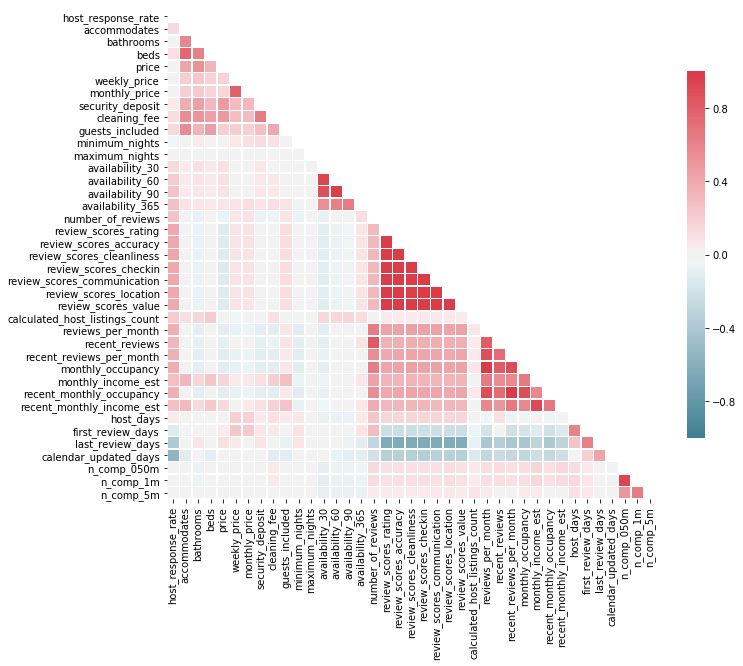

In [22]:
# Create correlation of continuous columns
corr = listings[cont_cols_no_ln].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin = -1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .75})

In [23]:
#get list of top correlated variables
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(listings[cont_cols_no_ln], 50))

Top Absolute Correlations
reviews_per_month            monthly_occupancy              1.000000
recent_reviews_per_month     recent_monthly_occupancy       1.000000
review_scores_checkin        review_scores_communication    0.991191
review_scores_rating         review_scores_accuracy         0.990212
review_scores_accuracy       review_scores_communication    0.988792
review_scores_rating         review_scores_communication    0.988605
review_scores_checkin        review_scores_value            0.987132
review_scores_rating         review_scores_cleanliness      0.987088
review_scores_accuracy       review_scores_checkin          0.986884
                             review_scores_value            0.986378
review_scores_checkin        review_scores_location         0.986292
review_scores_rating         review_scores_value            0.986278
review_scores_accuracy       review_scores_cleanliness      0.986008
review_scores_location       review_scores_value            0.985553
review_s

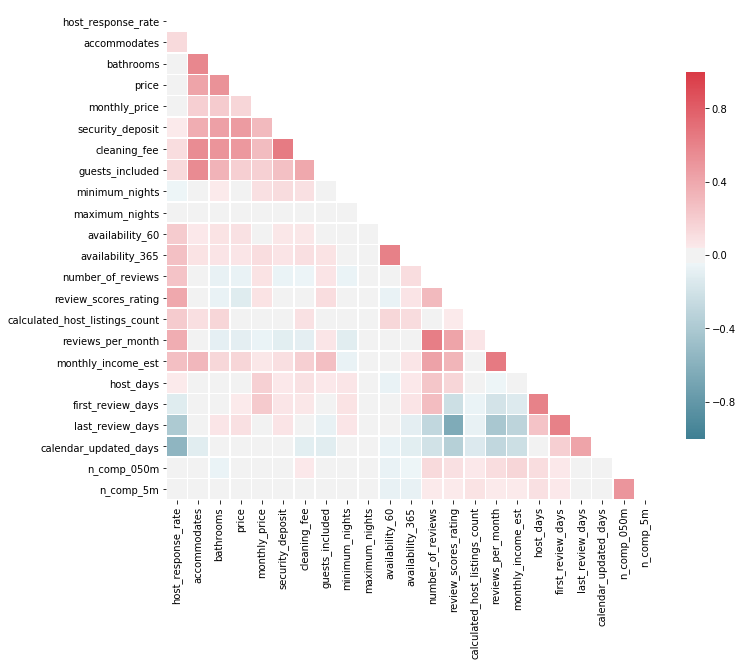

In [24]:
#drop correlated variables
drop_cols= ['beds',
            'availability_30',
            'availability_90',
            'review_scores_accuracy',
            'review_scores_checkin',
            'review_scores_location',
            'review_scores_cleanliness',
            'review_scores_communication',
            'review_scores_value',
            'recent_reviews_per_month', 
            'monthly_occupancy',
            'monthly_occupancy_ln',
            'recent_reviews',
            'recent_monthly_occupancy',
            'recent_monthly_occupancy_ln',
            'recent_monthly_income_est',
            'recent_monthly_income_est_ln',
            'n_comp_1m',
            'n_comp_1m_ln',
            'weekly_price',
            'weekly_price_ln']

cont_cols_no_ln = [x for x in cont_cols_no_ln if x not in drop_cols]
cont_cols = [x for x in cont_cols if x not in drop_cols]


listings = listings.drop(drop_cols, axis=1)

#check correlation plot again
corr = listings[cont_cols_no_ln].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin = -1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .75})

<a id='exploration'></a>

## VII. Data Exploration

Now that I have the final variables set, its time to explore the data. To bettter understand the data, I answered the following questions:

1. How many listings per year?  How many listings discontinue?
2. Where are listings located?
3. What factors are associated with drop out?
<br>
 -neighbourhood
</br>
<br>
 -rental type
</br>
<br>
 -host status or location type
</br>
<br>
 -listing factors (income, competition, reviews, etc) 
</br>

### How many listings per year? How many listings discontinue per year?

AirBnb saw tremendous growth from 2015-2017 almost doubling the number of listings from 15,000 to 30,000.  However, this growth masks the consistently high turnover seen during this time period.   For example, nearly one third of listings from 2017 dropped out a year later. This high turonver rate warrants a closer look.  

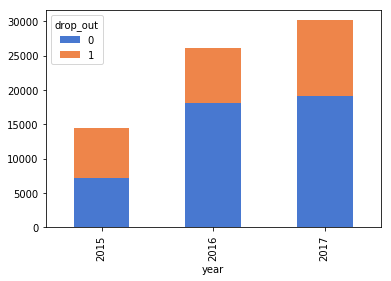

In [25]:
#How many listings per year?
#How many lisings discontinue per year?
sum_17 = listings_2017.drop_out.value_counts(dropna = False)
sum_16 = listings_2016.drop_out.value_counts(dropna = False)
sum_15 = listings_2015.drop_out.value_counts(dropna = False)

sum_17 = sum_17.to_frame()
sum_17['year'] = 2017
sum_16 = sum_16.to_frame()
sum_16['year'] = 2016
sum_15 = sum_15.to_frame()
sum_15['year'] = 2015

sums = pd.concat([sum_15, sum_16, sum_17])
sums = sums.reset_index()
sums.columns = ['drop_out', 'listings', 'year']

pal_dropout = ['#4878d0','#ee854a']
sums.pivot('year', 'drop_out')['listings'].plot(kind='bar', stacked=True, color = pal_dropout)

### Where are listings located?

Maps are a natural way to view geographic data.  Bokeh allows us to overlay points on a map and embed information in the points.

Listings are not uniformly distributed throughout Los Angeles.  Instead they are concentrated along the center of the county with the most popular neighbourhoods being Venice (2045 listings), Hollywood (1981), Long Beach (1043), and Santa Monica (911).  These neighbourhoods are popular tourist areas, suggesting that a lot of AirBnb rentals in Los Angeles cater to tourists.  

In [26]:
config = configparser.ConfigParser()
config.read('API_KEYS.ini')
config.sections()

API_KEY = config['google.com']['API_KEY']

#Map the listings
#Set up google maps
gkey = API_KEY
map_options = GMapOptions(lat=34.0522, lng=-118.2437, map_type="roadmap", zoom=10)
p = gmap(gkey, map_options, tools=['wheel_zoom', 'pan', 'reset'], plot_width=1000, plot_height=900)


# Get the number of colors we'll need for the plot.
colors = pal_dropout

# Create a color map for drop_out values: blue for 0, orange for 1
colormap = {i: colors[i] for i in listings.drop_out.unique()} 

# Create a list of colors for each value that we will be looking at.
colors = [colormap[x] for x in listings.drop_out]


#Add listing points as a Column Data Source
listings['drop_out_color'] = colors
listings_col = ColumnDataSource(listings[['latitude', 'longitude', 'drop_out', 'drop_out_color']])
listings_mp = p.circle('longitude', 'latitude', source = listings_col, color= '#4878d0', size=1)



listings_mp_hover = HoverTool(renderers=[listings_mp])
listings_mp_hover.tooltips=[("id", "@id"),
                            ("drop_out", '@drop_out'),]
p.add_tools(listings_mp_hover)
p.add_tile(CARTODBPOSITRON)


output_notebook()

show(p)


Loading BokehJS ...

In [27]:
neighbourhoods_shapes = gpd.read_file('InsideAirBnb/neighbourhoods_17.geojson')
neighbourhoods_shapes['neighbourhood'] = neighbourhoods_shapes['neighbourhood'].str.lower()

neighbourhoods = listings.groupby('neighbourhood_cleansed')['drop_out'].agg({'listings': np.size, 'dropout_p': np.mean})
neighbourhoods = neighbourhoods[neighbourhoods['listings'] > 50]
neighbourhoods.reset_index(inplace = True)

neighbourhoods = pd.merge(neighbourhoods, neighbourhoods_shapes, left_on = 'neighbourhood_cleansed', right_on = 'neighbourhood', how = 'left')
neighbourhoods = neighbourhoods.drop(['neighbourhood', 'neighbourhood_group'], axis=1)
gdf = gpd.GeoDataFrame(neighbourhoods, geometry='geometry')
geo_source = GeoJSONDataSource(geojson = gdf.to_json())

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


In [28]:
colormap_neighbourhood = LinearColorMapper(palette=cc.blues, low=0, high=neighbourhoods.listings.max())

p = gmap(gkey, map_options, tools=['wheel_zoom', 'pan', 'reset'], plot_width=1000, plot_height=900)

neighbourhood_mp = p.patches('xs', 'ys', fill_alpha=0.9, fill_color={'field': 'listings', 'transform': colormap_neighbourhood},
          line_color='black', line_width=0.5, source=geo_source)

nbhover = HoverTool(renderers=[neighbourhood_mp])
nbhover.tooltips=[("Neighbourhood", "@neighbourhood_cleansed"),
       ("Percent Drop Out", "@dropout_p{(.0000)}"),
       ("Listings", "@listings"),
       ]
p.add_tools(nbhover)
p.add_tile(CARTODBPOSITRON)

color_bar = ColorBar(color_mapper=colormap_neighbourhood, label_standoff=12, border_line_color=None, location=(0,0), orientation = 'horizontal')

p.title.text = "Listings per neighbourhood with more than 50 listings"
p.title.align = "center"

p.add_layout(color_bar, 'above')

show(p)

## What neighborhoods are associated with drop out?
Neighborhood drop out rates in 2017 ranged from 14% in Jefferson Park to 59% in Diamond Bar.  Over 50% of listings drop out the following year in 10 of the 106 neighbourhoods with more than 50 listings.   

In [29]:
colormap_neighbourhood = LinearColorMapper(palette=cc.blues, low=neighbourhoods.dropout_p.min(), high=neighbourhoods.dropout_p.max())

p = gmap(gkey, map_options, tools=['wheel_zoom', 'pan', 'reset'], plot_width=1000, plot_height=900)

neighbourhood_mp = p.patches('xs', 'ys', fill_alpha=0.9, fill_color={'field': 'dropout_p', 'transform': colormap_neighbourhood},
          line_color='black', line_width=0.5, source=geo_source)

nbhover = HoverTool(renderers=[neighbourhood_mp])
nbhover.tooltips=[("Neighbourhood", "@neighbourhood_cleansed"),
       ("Percent Drop Out", "@dropout_p{(0.000)}"),
       ("Listings", "@listings"),
       ]
p.add_tools(nbhover)
p.add_tile(CARTODBPOSITRON)

color_bar = ColorBar(color_mapper=colormap_neighbourhood, label_standoff=12, border_line_color=None, location=(0,0), orientation = 'horizontal')
p.add_layout(color_bar, 'above')

p.title.text = "Drop out rate among neighbourhoods with more than 50 listings"
p.title.align = "center"

show(p)

In [30]:
#Neighborhood
pd.set_option('display.max_rows', 260)
x = listings.groupby('neighbourhood_cleansed')['drop_out'].agg({'N': np.size, 'dropout_p': np.mean})
x[x['N'] > 50].sort_values('dropout_p', ascending = False)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


N  dropout_p
neighbourhood_cleansed                                
diamond bar                              78   0.589744
walnut                                   75   0.573333
chinatown                                65   0.569231
playa vista                              87   0.563218
west covina                              66   0.560606
marina del rey                          163   0.539877
arcadia                                 169   0.538462
boyle heights                            88   0.534091
canoga park                              61   0.524590
rancho palos verdes                      56   0.517857
beverly crest                           145   0.517241
exposition park                         140   0.492857
hawthorne                                67   0.477612
downtown                                896   0.469866
larchmont                               122   0.450820
brentwood                               208   0.442308
rowland heights                         335   0.441791
pico-robertson                          204   0.441176
baldwin hills/crenshaw                   64   0.437500
hollywood                              1918   0.431700
northridge                               72   0.430556
palms                                   311   0.427653
sun valley                               61   0.426230
koreatown                               616   0.425325
santa clarita                            87   0.425287
van nuys                                204   0.421569
west hollywood                          834   0.417266
santa monica                            911   0.414929
mid-wilshire                            714   0.411765
lincoln heights                          56   0.410714
monterey park                           118   0.406780
north hollywood                         433   0.406467
westwood                                460   0.404348
vermont square                           58   0.396552
encino                                  139   0.395683
hacienda heights                         79   0.392405
long beach                             1043   0.390221
inglewood                               166   0.385542
tarzana                                 109   0.385321
sawtelle                                508   0.383858
arlington heights                       115   0.382609
studio city                             366   0.382514
el segundo                               92   0.380435
sherman oaks                            424   0.379717
fairfax                                 384   0.377604
west hills                               67   0.373134
westlake                                464   0.372845
mar vista                               400   0.372500
hollywood hills west                    452   0.369469
harvard heights                          76   0.368421
malibu                                  316   0.367089
south pasadena                           63   0.365079
san gabriel                              96   0.364583
east hollywood                          419   0.362768
playa del rey                           118   0.355932
westchester                             184   0.353261
hermosa beach                           139   0.352518
glassell park                            88   0.352273
hollywood hills                         767   0.349413
temple city                              83   0.349398
west los angeles                        118   0.347458
gardena                                  72   0.347222
beverly hills                           380   0.344737
pomona                                   96   0.343750
beverly grove                           515   0.343689
woodland hills                          262   0.343511
pacific palisades                       186   0.338710
burbank                                 249   0.337349
mid-city                                400   0.335000
west adams                               63   0.333333
view park-windsor hills                  64   0.328125
el sereno                  

### What rental type factors are associated with drop out?

Condominiums, lofts, townhouses, and apartments have the highest drop out rates.  However, the room_type may be the most important rental type factor.  Shared room listings have also 60% probability of dropping out whereas private rooms or entire home listings have less than 40% probability of dropping out

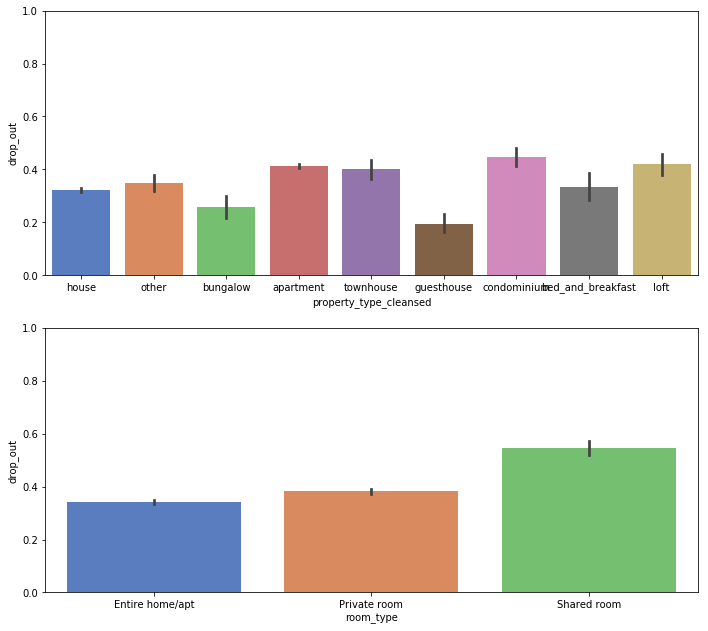

In [31]:
#Property_type
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize=(11.7, 10.7))

sns.catplot(ax = ax1, x="property_type_cleansed", y="drop_out", data = listings, 
                   height=6, kind="bar", palette="muted")
sns.catplot(ax = ax2, x="room_type", y="drop_out", data = listings,
                   height=6, kind="bar", palette="muted")

ax1.set(ylim=(0, 1))
ax2.set(ylim=(0, 1))

plt.close(2)
plt.close(3)

### What host factors are associated with drop out?

Listing hosts that are super hosts or live in the same neighborhood as the listing tend to have lower drop out rates.  Also hosts of listings that are retained the next year have been hosting longer than hosts of listings drop out.  

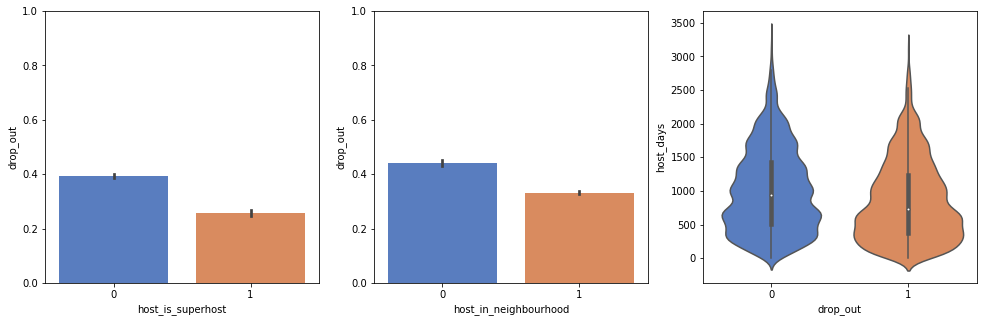

In [32]:
#superhost status
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3,figsize=(16.7, 5))
ax1.set(ylim=(0, 1))
ax2.set(ylim=(0, 1))

sns.catplot(x="host_is_superhost", y="drop_out", data = listings,
                   height=6, kind="bar", palette="muted", ax = ax1)
sns.catplot(x="host_in_neighbourhood", y="drop_out", data = listings,
                   height=6, kind="bar", palette="muted", ax = ax2)
sns.violinplot(x = "drop_out", y = "host_days", data=listings, palette=pal_dropout, ax = ax3)

plt.close(2)
plt.close(3)

### What other factors are associated with drop out?

When looking at metrics related to listing popularity, there is little difference between listings that drop out and listings that are retained the next year.  Both listing types have a similar number of competitors within a half mile and within a mile radii. Both listings also have prices, recent monthly occupancy, and recent estimated monthly income.  There are some differences: listings that do not drop out have more reviews, a slightly higher rating, and less availability for the next 60 days, but its unclear whether this difference is meaningful. 

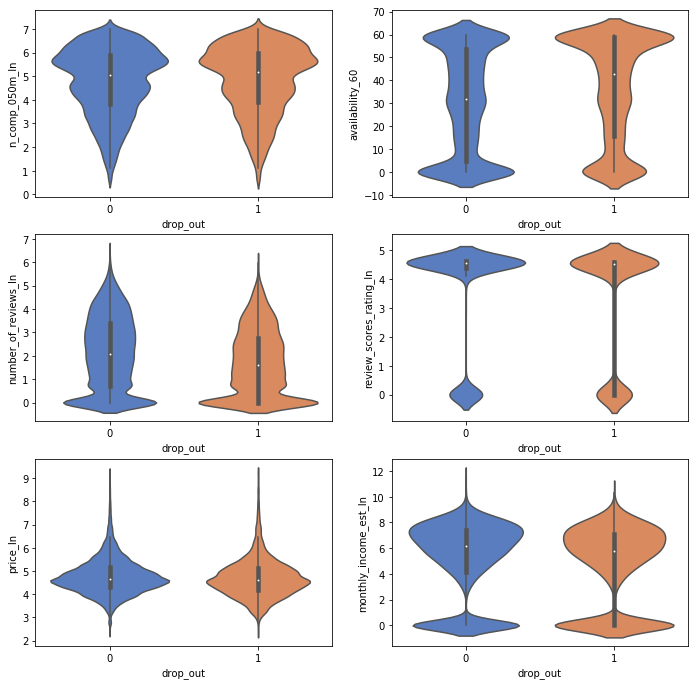

In [33]:
#Plots of listing popularity, price, and nearby competitors

fig, axs = plt.subplots(nrows = 3, ncols = 2,figsize=(11.7, 11.7))

sns.violinplot(x="drop_out", y="n_comp_050m_ln", palette=pal_dropout, data=listings, ax=axs[0,0])
sns.violinplot(x="drop_out", y="availability_60", data=listings, palette=pal_dropout, ax = axs[0,1])
sns.violinplot(x="drop_out", y="number_of_reviews_ln", data=listings, palette=pal_dropout, ax = axs[1,0])
sns.violinplot(x="drop_out", y="review_scores_rating_ln", data=listings, palette=pal_dropout, ax=axs[1,1])
sns.violinplot(x="drop_out", y="price_ln", data=listings, palette=pal_dropout, ax = axs[2,0])
sns.violinplot(x="drop_out", y="monthly_income_est_ln", data=listings, palette=pal_dropout, ax = axs[2,1])

### Assessment

Overall, neighbourhood, property type and host factors seem to have the strongest association with drop out status.  Listing popularity and monthly income do not seem to strongly predict drop out status.  

<a id = 'pipeline'></a>
## Pipeline Assembly


To prepare the data for the pipeline I convert categorical features to dummy variables, split the data, and determine the number of PCA dimensions to use.  Based on the graph below, 10 PCA components seems like a reasonable number

The pipeline I built pipeline will scale the continuous columns and reduce them through PCA before appending to the categorical variables and feeding into a variety of default estimators.  The estimator with the best accuracy score will be the focus for hyperparameter tuning in the next step.


In [34]:
#convert categorical variables to dummys
cols_init = listings.columns.values
listings = pd.get_dummies(listings, columns = cat_cols, drop_first=True)
cols_new = listings.columns.values
cat_cols = list(set(cols_new).difference(set(cols_init)))

#split data into test, train sets
X = listings.drop('drop_out', axis=1)
y = listings['drop_out']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

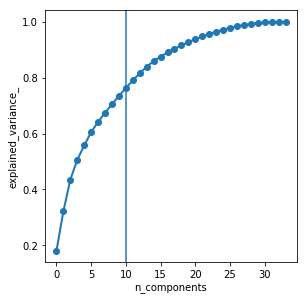

In [35]:
#based on PCA, use 10 dimensions
decomp = PCA()

std = StandardScaler()
decomp.fit(std.fit_transform(X_train[cont_cols]))

plt.figure(1, figsize=(5, 5))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(np.cumsum(decomp.explained_variance_ratio_), linewidth=2, marker = 'o')
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.axvline(x=10)

In [36]:
#Construct Pipeline
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select columns from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class ArrayTransformer(BaseEstimator, TransformerMixin):
    """
    Transformer to select columns from the data frame to change to array
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array(X[self.key])



cont_scale =  Pipeline([
                ('selector', ColumnSelector(key=cont_cols)),
                ('standardize', StandardScaler()),
                ('pca', PCA(n_components = 10))
                ])

oth_cols = Pipeline([
                ('others', ArrayTransformer(binary_cols+cat_cols))
                ])

pipeline = Pipeline([
           ('Union', FeatureUnion([
               ('continous', cont_scale),
               ('others', oth_cols)
            ])),
           ('clf', SGDClassifier(loss = 'log', penalty = 'elasticnet', max_iter = 120))
           ])

cols = ['pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10'] + binary_cols + cat_cols

In [52]:
#Create a list of classifiers to test
clfs = []
clfs.append(SGDClassifier(loss = 'log', penalty = 'elasticnet', max_iter = 120))
clfs.append(RandomForestClassifier())

#Run through the pipeline for each classifier in the list
#Can take awhile to run
for classifier in clfs:
    pipeline.set_params(clf = classifier)
    scores = cross_validate(pipeline, X_train, y_train, scoring = 'recall', return_train_score = False, cv = 5)
    print('---------------------------------')
    print(str(classifier))
    print('-----------------------------------')
    for key, values in scores.items():
            print(key,' mean ', values.mean())
            print(key,' std ', values.std())

---------------------------------
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=120, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
-----------------------------------
fit_time  mean  1.2058035850524902
fit_time  std  0.01942217671932986
score_time  mean  0.006788396835327148
score_time  std  0.0002057482772393764
test_score  mean  0.38598027876926755
test_score  std  0.08885903112423076
---------------------------------
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            

<a id = 'tuning'></a>
## Hyperparameter Tuning

Logistic Regression provides the best accuracy results.  Tuning the hyperparameter l1_ratio may provide better results. 

In [53]:
pipeline = Pipeline([
           ('Union', FeatureUnion([
               ('continous', cont_scale),
               ('others', oth_cols)
            ])),
           ('clf', SGDClassifier(loss = 'log', penalty = 'elasticnet', max_iter = 120))
           ])

cols = ['pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10'] + binary_cols + cat_cols

param_grid = {
    'clf__l1_ratio' :  np.linspace(0.1,1,12),
}

cv_grid = GridSearchCV(pipeline, param_grid = param_grid, scoring = 'recall', cv = 5, verbose = 1)

In [54]:
model = cv_grid.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.2min finished


In [55]:
print('Parameters:', model.best_params_)
print('Best Recall Score:', model.best_score_)

Parameters: {'clf__l1_ratio': 0.26363636363636367}
Best Recall Score: 0.3891901027039615


The hyperparameter search didn't do much better than the defaults, which may suggest that there is not much optimization to be done.  We can evaluate the overall fit of the model by reviewing the ROC curve, and the default accuracy, precision, and recall.

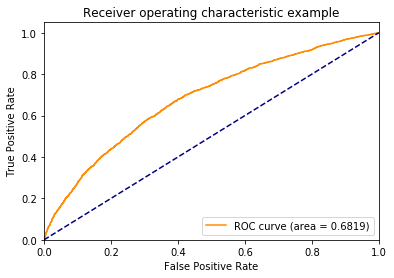

Confusion Matrix: 
 [[4701 1020]
 [1962 1363]]
Accuracy: 67.035%
Recall: 40.992%
Precision: 57.197%


In [56]:
# Compute ROC curve and ROC area
fpr = dict()
tpr = dict()
roc_auc = dict()
y_score = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

y_predict = model.predict(X_test)
accuracy = accuracy_score(y_test,y_predict)
recall = recall_score(y_test,y_predict)
precision = precision_score(y_test,y_predict)

print('Confusion Matrix: \n', confusion_matrix(y_test, y_predict))
print('Accuracy: %.3f%%' % (accuracy*100))
print('Recall: %.3f%%' % (recall*100))
print('Precision: %.3f%%' % (precision*100))

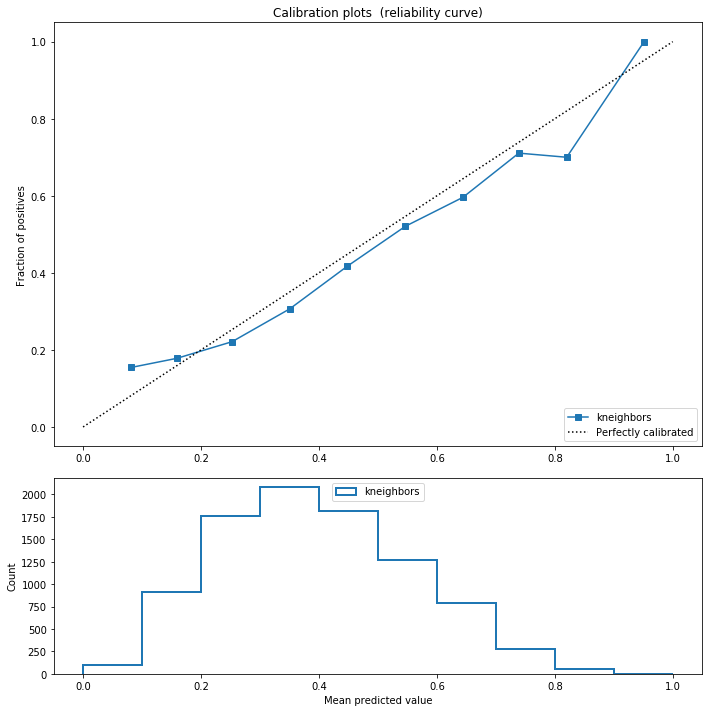

In [81]:
#Calibration Plot
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_score, n_bins=10)

fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label='kneighbors')
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

ax2.hist(y_score, range=(0, 1), bins=10, label='kneighbors', histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

plt.show()

In [86]:
#Get feature importances by getting accuracy per each feature
coefficients = model.best_estimator_.named_steps['clf'].coef_
coefficients = np.squeeze(coefficients)
coefficients = pd.DataFrame(
    {'features': cols,
     'coefficients': coefficients
    })

coefficients.set_index('features', inplace = True)
coefficients['abs'] = abs(coefficients['coefficients'])
coeffcients = coefficients.sort_values(by= ['abs'], ascending = False, inplace = True)
coefficients['coefficients'][:15]

features
host_response_missing                      -1.203243
cancellation_policy_super_strict_60         1.199516
property_type_cleansed_guesthouse          -1.071493
property_type_cleansed_bed_and_breakfast   -0.556139
host_response_time_within an hour          -0.534730
host_response_time_within a few hours      -0.504342
property_type_cleansed_bungalow            -0.453078
property_type_cleansed_other               -0.420672
property_type_cleansed_house               -0.419372
host_is_superhost                          -0.370213
host_v_reviews                              0.358305
room_type_Shared room                       0.326935
host_in_neighbourhood                      -0.288327
require_guest_phone_verification           -0.244945
require_guest_profile_picture               0.244551
Name: coefficients, dtype: float64

Based on our final logistic regression model, the most important features are related to host responsiveness, strictness, and property type. Hosts that are super hosts, colocated with their listing,  and respond most quickly to guest queries are less likely to drop their listings next year.  Hosts that are very strict either by having a broad cancellation policy or by requiring phone verification are more likely to drop out.  Property and room type also matters.  Guesthouses, bed and breakfasts, bungalows, and houses are less likely to drop out next year.  However, shared room listings are likely most likely to drop out.  These results comport with our EDA findings.  

<a id = 'tsne'></a>
## TSNE

Although all our algorithms give a similar accuracy, there may be some combination of features that can better separate the classes but which weren't included in the model.  I used t-SNE to cluster records based on all the features.  If there is some way to separate the classes, we might see a cluster of misclassified records that are fairly distinct from the rest of the population.   

In [82]:
#tsne
from sklearn.manifold import TSNE

combine = Pipeline([
           ('Union', FeatureUnion([
               ('continous', cont_scale),
               ('others', oth_cols)
            ])),
            ('tsne', TSNE(n_components=2, verbose=1, perplexity=12, n_iter=300))
])

tsne = combine.fit_transform(X_test)

[t-SNE] Computing 37 nearest neighbors...
[t-SNE] Indexed 9046 samples in 0.014s...
[t-SNE] Computed neighbors for 9046 samples in 4.908s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9046
[t-SNE] Computed conditional probabilities for sample 2000 / 9046
[t-SNE] Computed conditional probabilities for sample 3000 / 9046
[t-SNE] Computed conditional probabilities for sample 4000 / 9046
[t-SNE] Computed conditional probabilities for sample 5000 / 9046
[t-SNE] Computed conditional probabilities for sample 6000 / 9046
[t-SNE] Computed conditional probabilities for sample 7000 / 9046
[t-SNE] Computed conditional probabilities for sample 8000 / 9046
[t-SNE] Computed conditional probabilities for sample 9000 / 9046
[t-SNE] Computed conditional probabilities for sample 9046 / 9046
[t-SNE] Mean sigma: 1.043172
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.007454
[t-SNE] Error after 300 iterations: 3.697243


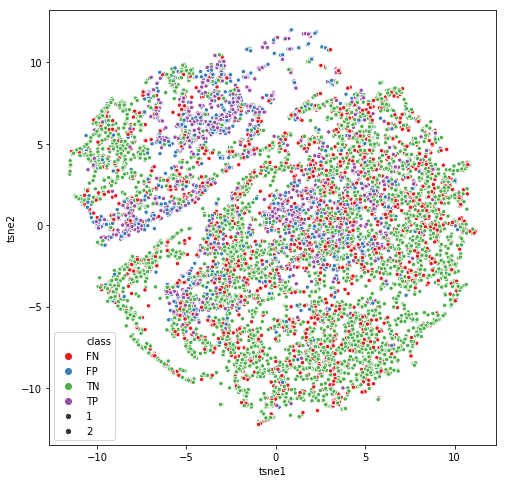

In [83]:
def result_type(row):
    if row['drop_out'] == 0:
        if row['prediction'] == 0:
            return 'TN'
        elif row['prediction'] == 1:
            return 'FP'
    elif row['drop_out'] == 1:
        if row['prediction'] == 1:
            return 'TP'
        elif row['prediction'] == 0:
            return 'FN'

conf_mat = y_test.copy()
conf_mat = pd.DataFrame(conf_mat)
conf_mat['prediction'] = y_predict
conf_mat['class'] = conf_mat.apply(result_type, axis = 1)
conf_mat['tsne1'] = tsne[:,0]
conf_mat['tsne2'] = tsne[:,1]

colors = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3"]
sns.set_palette(colors)

class_order = ['FN', 'FP', 'TN', 'TP']

f, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x="tsne1", y="tsne2", hue="class", 
                hue_order=class_order, size = 2, data=conf_mat, ax = ax)

Based on this graphic, the false negatives are randomly distributed among the true negatives.  Similarly, the false positives and true positives tend to colocate together.  This indicates that there is no clear way to separate the classes based on the current data.

<a id = 'conclusion'></a>
## XI. Conclusion

In summary, I developed a predictive model that identified listings at risk for drop out with reasonable accuracy.  Although the accuracy and AUCROC are fairly moderate at around 67-68%, this may be the best we can do with the given data as t-SNE did not suggest a better separation of the classes.  Additional data such as NLP analyses of the text features, external data about the housing market in the areas around listings, or more extensive host data might provide more distinguishing features.  Other models such as SVC, neural networks, or KNeighbors may have provided better results.  However, because explainability is important, we focused on the two most interpretable models.

The logistic regression results demonstrate that host and property factors are the main predictors of drop out.  Hosts that are attentive to guests and active on the platform are less likely to drop out. Hosts that have strict cancellation and reservation policies as well as hosts who are located in a different area from their listing are more likely to drop out.  Also, listings for spaces spcifically made for guests like bungalows, bed and breakfasts, or guest houses are less likely to drop out while listings for shared spaces are more likely to drop out.  Interestingly pca components that capture listing price, popularity, or review ratings didn't have a large effect on the model.

This suggests that the most important factors are related to the host.  Indeed maintaining a listing is a substantial burden on hosts, especially on those who share space with their guests or live far away from their listing.  Hosts able to bear it well because they have a separate or large space to host guests without much inconvenience are more likely to stay listed.  Also, hosts have the flexbility to be very responsive and attentive to guests and therefore don't place a lot of restrictions on reservations or cancellations are also likely to stay listed.

Despite modest predictive value, this model is still useful for the business.  I identified 41% of those listings that dropped out.  These listings may be pre-emptively targetted for additional outreach and support to help with the burden of hosting.  If the interventions were only 50% effective, the drop out rate could be reduced from 37% to 30%.  For the Los Angeles market, this would mean that over 2200 additional listings would be available in 2018 generating revenue and providing guests with more choice.
